# read in images

In [11]:
import cv2
import pickle as pk
import os

img_data, labels = [], []

data_path = "dataset"
        
for cls in os.listdir(data_path):

    cls_path = os.path.join(data_path, cls)
    for file in os.listdir(cls_path):

        if file.endswith('jpg'):
            file_path = os.path.join(cls_path, file)
            
            # read in an image in grayscale
            img_gray = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            img_data.append(img_gray)
            labels.append(cls)

data_file = open('data/data.pkl', 'wb')

pk.dump(img_data, data_file)

labels_file = open('data/labels.pkl', 'wb')

pk.dump(labels, labels_file)

print('Total images: ' + str(len(img_data)))
print('Total labels: ' + str(len(labels)))
print('Done!')

Total images: 36576
Total labels: 36576
Done!


# Encoder labels

In [67]:
import numpy as np
from sklearn import preprocessing, model_selection
import pandas as pd

letters = ['A','B','C','D','E','F','G','H','I','J',
           'K','L','M','N','O','P','Q','R','S','T',
           'U','V','W','X','Y','Z','0','1','2','3',
           '4','5','6','7','8','9',]

# Load pickled dataset
data_file = open("data/data.pkl", "rb")
labels_file = open("data/labels.pkl", "rb")
data = pkl.load(data_file)
labels = pkl.load(labels_file)

# Convert data[list] to data[numpy array]
data = np.array(data)


labels_list = []
for label in labels:
    labels_list.append([label])
    

classes = []
for cls in letters:
    classes.append([cls])
    
#Perform one hot encoding for the labels    
le = OneHotEncoder(handle_unknown='ignore')
le.fit(classes)

y_hot = le.transform(labels_list).toarray()
y_hot.shape

(36576, 36)

# check images and labels for one hot encoding

[['T']]


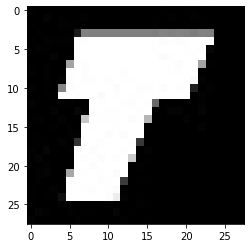

In [70]:
rnd = random.randint(0, len(img_data))

plt.imshow(data[rnd], cmap=plt.cm.gray)
print(le.inverse_transform([y_hot[rnd]]))

# split data to train, test

In [173]:
X_tr, X_te, y_tr, y_te = model_selection.train_test_split(data, y_hot, test_size=0.2, random_state=123)

X_tr = X_tr.reshape(len(X_tr), 28, 28, 1)
X_te = X_te.reshape(len(X_te), 28, 28, 1)

print(X_tr.shape,y_tr.shape,X_te.shape,y_te.shape)


print("Number of original training examples:", len(X_tr))
print("Number of original testing examples:", len(X_te))


(29260, 28, 28, 1) (29260, 36) (7316, 28, 28, 1) (7316, 36)
Number of original training examples: 29260
Number of original testing examples: 7316


# random forest

In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
model1 = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=0)
model1.fit(X_tr.reshape(len(X_tr), 28*28), y_tr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [93]:
y_pred1 = model1.predict(X_te.reshape(len(X_te), 28*28)).argmax(axis=1)
sum(1*(y_pred1 == y_te.argmax(axis=1)))/len(y_pred1)

0.7176052487698196

In [98]:
model3 = RandomForestClassifier(n_estimators = 50, criterion = 'entropy', random_state=0)
model3.fit(X_tr.reshape(len(X_tr), 28*28), y_tr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [99]:
y_pred3 = model3.predict(X_te.reshape(len(X_te), 28*28)).argmax(axis=1)
sum(1*(y_pred3 == y_te.argmax(axis=1)))/len(y_pred3)

0.7524603608529251

In [94]:
model2 = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state=0)
model2.fit(X_tr.reshape(len(X_tr), 28*28), y_tr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [96]:
y_pred2 = model2.predict(X_te.reshape(len(X_te), 28*28)).argmax(axis=1)
sum(1*(y_pred2 == y_te.argmax(axis=1)))/len(y_pred2)

0.7554674685620558

No handles with labels found to put in legend.


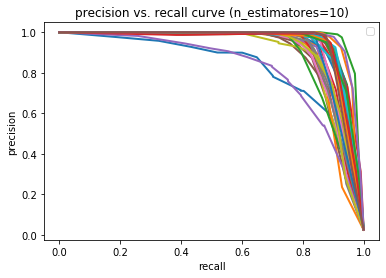

In [144]:
# plot ROC and PR curve for best model for test data
y_score = model1.predict_proba(X_te.reshape(len(X_te), 28*28))
precision = dict()
recall = dict()
for i in range(36):
    precision[i], recall[i], _ = precision_recall_curve(y_te[:, i], y_score[i][:,1])
    plt.plot(recall[i], precision[i], lw=2)
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve (n_estimatores=10)")
plt.show()

No handles with labels found to put in legend.


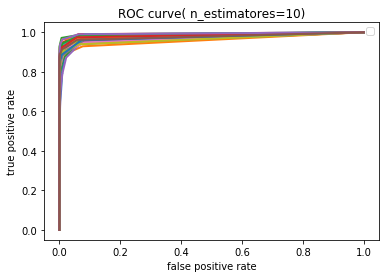

In [148]:
fpr = dict()
tpr = dict()

for i in range(36):
    fpr[i], tpr[i], _ = roc_curve(y_te[:, i],y_score[i][:,1])
    plt.plot(fpr[i], tpr[i], lw=2)

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve( n_estimatores=10)")
plt.show()

No handles with labels found to put in legend.


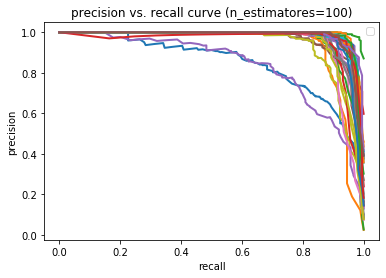

In [149]:
# plot ROC and PR curve for best model for test data
y_score = model2.predict_proba(X_te.reshape(len(X_te), 28*28))
precision = dict()
recall = dict()
for i in range(36):
    precision[i], recall[i], _ = precision_recall_curve(y_te[:, i], y_score[i][:,1])
    plt.plot(recall[i], precision[i], lw=2)
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve (n_estimatores=100)")
plt.show()

No handles with labels found to put in legend.


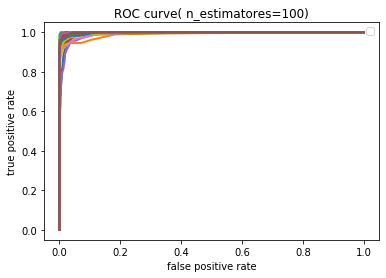

In [150]:
fpr = dict()
tpr = dict()

for i in range(36):
    fpr[i], tpr[i], _ = roc_curve(y_te[:, i],y_score[i][:,1])
    plt.plot(fpr[i], tpr[i], lw=2)

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve( n_estimatores=100)")
plt.show()

No handles with labels found to put in legend.


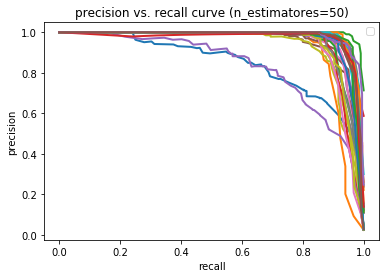

In [151]:
# plot ROC and PR curve for best model for test data
y_score = model3.predict_proba(X_te.reshape(len(X_te), 28*28))
precision = dict()
recall = dict()
for i in range(36):
    precision[i], recall[i], _ = precision_recall_curve(y_te[:, i], y_score[i][:,1])
    plt.plot(recall[i], precision[i], lw=2)
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve (n_estimatores=50)")
plt.show()

No handles with labels found to put in legend.


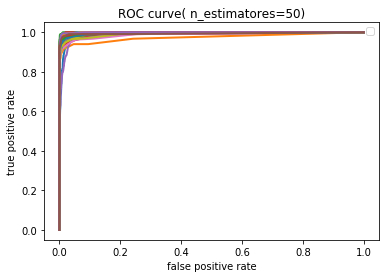

In [152]:
fpr = dict()
tpr = dict()

for i in range(36):
    fpr[i], tpr[i], _ = roc_curve(y_te[:, i],y_score[i][:,1])
    plt.plot(fpr[i], tpr[i], lw=2)

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve( n_estimatores=50)")
plt.show()

# random forest after TSNE 

In [101]:
# random forest after TSNE 
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(X_tr.reshape(len(X_tr), 28*28))

AttributeError: 'TSNE' object has no attribute 'transform'

No handles with labels found to put in legend.


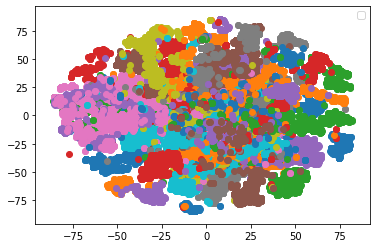

In [102]:
for i in range(36):
    plt.scatter(X_2d[y_tr.argmax(axis=1) == i, 0], X_2d[y_tr.argmax(axis=1) == i, 1])
plt.legend()
plt.show()

In [103]:
# random forest after TSNE 
model4 = RandomForestClassifier(random_state=0)
model4.fit(X_2d, y_tr)

/home/huachao/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [109]:
y_pred4 = model4.predict(X_2d).argmax(axis=1)
sum(1*(y_pred4 == y_tr.argmax(axis=1)))/len(y_pred4)

0.981203007518797

No handles with labels found to put in legend.


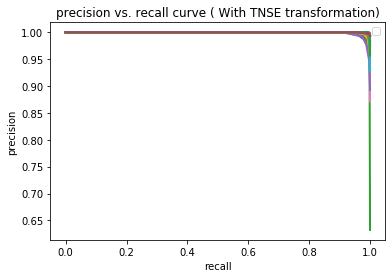

In [161]:
y_score = model4.predict_proba(X_2d)
precision = dict()
recall = dict()
for i in range(36):
    precision[i], recall[i], _ = precision_recall_curve(y_tr[:, i], y_score[i][:,1])
    plt.plot(recall[i], precision[i], lw=2)
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve ( With TNSE transformation)")
plt.show()

No handles with labels found to put in legend.


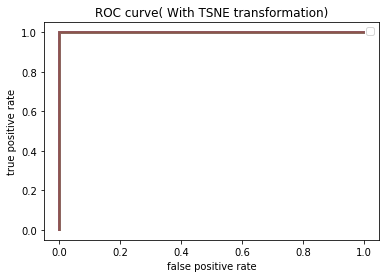

In [162]:
fpr = dict()
tpr = dict()

for i in range(36):
    fpr[i], tpr[i], _ = roc_curve(y_tr[:, i],y_score[i][:,1])
    plt.plot(fpr[i], tpr[i], lw=2)

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve( With TSNE transformation)")
plt.show()

# start build and train a CNN model

In [8]:
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
for physical_device in physical_devices: 
    tf.config.experimental.set_memory_growth(physical_device, True)

epochs = 20
    
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(36, activation='softmax')
])
    

print(model.summary())

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

model.fit(x_tr, y_tr, epochs=epochs, validation_data=(x_te, y_te), batch_size=64)

model.save('classifier_' + str(epochs) + '.h5')


print('Done!')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0

In [164]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
model = load_model('classifier_nor_20.h5')

No handles with labels found to put in legend.


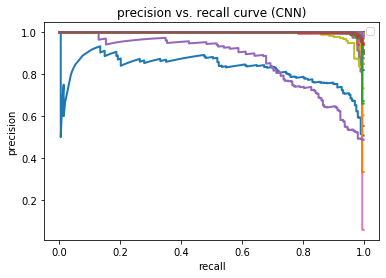

In [199]:
y_score = model.predict_proba(X_te)
precision = dict()
recall = dict()
for i in range(36):
    precision[i], recall[i], _ = precision_recall_curve(y_te[:, i], y_score[:,i])
    plt.plot(recall[i], precision[i], lw=2)
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve (CNN)")
plt.show()

No handles with labels found to put in legend.


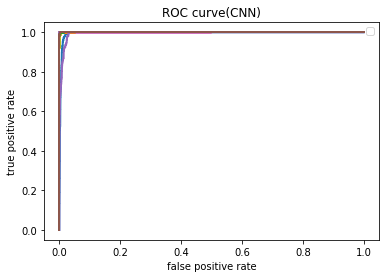

In [200]:
fpr = dict()
tpr = dict()

for i in range(36):
    fpr[i], tpr[i], _ = roc_curve(y_te[:, i],y_score[:,i])
    plt.plot(fpr[i], tpr[i], lw=2)

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve(CNN)")
plt.show()

In [174]:
y_pred = model.predict(X_te)

In [198]:
for i in range(36):
    a = np.zeros(36)
    a[i] = 1
    c = 0
    s = 0
    for j, y in enumerate(y_te.argmax(axis=1)):
        if y == i:
            s = s + 1
            if y_pred.argmax(axis=1)[j]== i:
                c = c + 1
    print(le.inverse_transform([a]),s,c,c/s)

[['0']] 208 183 0.8798076923076923
[['1']] 224 215 0.9598214285714286
[['2']] 209 208 0.9952153110047847
[['3']] 208 208 1.0
[['4']] 199 198 0.9949748743718593
[['5']] 200 199 0.995
[['6']] 213 211 0.9906103286384976
[['7']] 192 191 0.9947916666666666
[['8']] 219 217 0.9908675799086758
[['9']] 207 207 1.0
[['A']] 201 199 0.9900497512437811
[['B']] 183 180 0.9836065573770492
[['C']] 201 199 0.9900497512437811
[['D']] 206 205 0.9951456310679612
[['E']] 200 199 0.995
[['F']] 199 195 0.9798994974874372
[['G']] 217 211 0.9723502304147466
[['H']] 192 184 0.9583333333333334
[['I']] 193 188 0.9740932642487047
[['J']] 191 190 0.9947643979057592
[['K']] 213 211 0.9906103286384976
[['L']] 188 185 0.9840425531914894
[['M']] 198 197 0.9949494949494949
[['N']] 205 198 0.9658536585365853
[['O']] 209 145 0.69377990430622
[['P']] 212 210 0.9905660377358491
[['Q']] 214 210 0.9813084112149533
[['R']] 212 211 0.9952830188679245
[['S']] 197 195 0.9898477157360406
[['T']] 205 204 0.9951219512195122
[['U']] 